# Introduction
We will use a Kalman filter to estimate the state mean $\mu_{t-1}$ and state variance $\sigma_{t-1}^2$ of industry returns at time $t - 1$. To do this, we will use data from $t - 12$ to $t - 1$. Using this information, we will construct a signal for investment at time $t$ of the form
$$
\mu_{t-1} - \frac{\gamma}{2}\sigma_{t-1}^2.
$$
We will suppose $\gamma = 1$ in our calculations. The data were obtained from the Ken French Data Library. We used equally weighted monthly industry returns. The date range is from July 1927 to November 2020.

# Packages and Setup

In [243]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import os
os.chdir('/Users/charlesrambo/Desktop/GitHub data')

In [244]:
# Load equally weighted industry return data
industry = pd.read_csv('10_Industry_Portfolios.csv')

# Convert date column into date-time object
industry['Date'] = pd.to_datetime(industry['Date'], format = '%Y%m') + MonthEnd(0)

# Convert returns to a decimal 
industry.iloc[:, 1:] = industry.iloc[:, 1:].div(100)

industry.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,1926-07-31,0.0116,0.0403,0.0230,-0.0219,0.0221,0.0131,0.0069,0.0245,0.0485,0.0021
1,1926-08-31,0.0500,0.0028,0.0211,0.0441,0.0261,0.0108,-0.0003,0.0611,-0.0200,0.0453
2,1926-09-30,0.0003,-0.0334,0.0053,-0.0351,0.0086,0.0022,-0.0071,0.0080,0.0206,-0.0053
3,1926-10-31,-0.0255,-0.0946,-0.0511,0.0267,-0.0572,-0.0099,-0.0328,0.0013,-0.0298,-0.0251
4,1926-11-30,0.0600,-0.0038,0.0169,0.0159,0.0132,0.0148,0.0135,0.0720,0.0571,0.0085


We will use the EM method of the Kalman filter object to estimate the the parameters of the Kalman filter.

In [245]:
# Record the number of variables
n = 10

# Save identity matrix
I = np.eye(n)

# Create data frame to record signal values
kal_mom = pd.DataFrame(index = industry.index[12:], columns = industry.columns)

    
# Create filter
kf = KalmanFilter(initial_state_mean = np.zeros(n),
                initial_state_covariance =  0.10**2 * I,
                transition_matrices = I,
                observation_matrices = I,
                observation_covariance = 0.10**2 * I,
                transition_covariance = I)

# We will loop over the date
dates = np.unique(industry['Date'])[12:]

for date in dates:
    
    # Obtain the end of the signal formation, exclusive
    stop = np.sum(industry['Date'] < date)
    
    # Record the beginning of signal, inclusive
    start = stop - 12
    
    # Get 'measurement' values for Kalman filter
    X = np.array(industry.iloc[start:stop, 1:])
    
    try:
        
        kf = kf.em(X, n_iter = 5)
        mu, sigma = kf.smooth(X)
    
    except:
        
        # If det(X'X) is too small for Kalman filter, use 0 as state estimates
        mu, sigma = [np.zeros(n)], [np.zeros((10, 10))]
    
    # Record date for later merger
    kal_mom.loc[stop, 'Date'] = date    
    
    # Record signal
    kal_mom.loc[stop, industry.columns[1:]] = mu[-1] - 0.5 * np.diag(sigma[-1])
    
kal_mom.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
12,1927-07-31T00:00:00.000000000,0.00420937,-0.0171404,-0.00725721,0.0110815,0.0200335,-0.0122985,-0.00431213,0.039219,0.00326809,0.0127559
13,1927-08-31T00:00:00.000000000,0.0348868,0.0278157,0.041258,0.0165521,0.0486224,0.0198398,0.0301803,0.0644458,0.0221101,0.0306733
14,1927-09-30T00:00:00.000000000,0.0220896,0.0128971,0.0156961,0.00100684,0.00528674,0.0150913,0.028371,0.0349019,0.0428108,0.000556778
15,1927-10-31T00:00:00.000000000,0.0083215,0.00145627,0.00737759,0.00248127,0.00896752,0.0418756,0.0394634,0.0296938,0.0831032,0.00952527
16,1927-11-30T00:00:00.000000000,0.0250034,0.0194311,0.0184919,0.0364284,0.0300331,0.0119698,0.00441621,0.0573313,-2.28794e-05,0.0179479


All that is left is a little data wrangling.

In [246]:
# Change structure of data frame so industries are observations
kal_mom = pd.melt(kal_mom, id_vars = ['Date'], value_vars = kal_mom.columns[1:])

# Change column names
kal_mom.columns = ['Date', 'Industry', 'Kal_mom']

kal_mom.head()

,Date,Industry,Kal_mom
0,1927-07-31,NoDur,0.00420937
1,1927-08-31,NoDur,0.0348868
2,1927-09-30,NoDur,0.0220896
3,1927-10-31,NoDur,0.0083215
4,1927-11-30,NoDur,0.0250034


In [247]:
# Change structure of data frame so industries are observations
industry = pd.melt(industry, id_vars = ['Date'], value_vars = industry.columns[1:])

# Change column names
industry.columns = ['Date', 'Industry', 'Ret']

industry.head()

,Date,Industry,Ret
0,1926-07-31,NoDur,0.0116
1,1926-08-31,NoDur,0.0500
2,1926-09-30,NoDur,0.0003
3,1926-10-31,NoDur,-0.0255
4,1926-11-30,NoDur,0.0600


In [251]:
# Perform merge
df = industry.merge(kal_mom, on = ['Date', 'Industry'])

# Calculate quintiles
df['Quintile'] = df[['Date', 'Kal_mom']].groupby('Date')['Kal_mom'].transform(lambda x: pd.qcut(x, 5, labels = False))

# Add 1 to quintile to avoid confusion
df['Quintile'] = 1 + df['Quintile']

# Drop columns that have done their jobs
df.drop(['Kal_mom', 'Industry'], axis = 1, inplace = True)

df.head()

,Date,Ret,Quintile
0,1927-07-31,0.0649,3
1,1927-08-31,0.0119,4
2,1927-09-30,0.0291,4
3,1927-10-31,-0.0171,2
4,1927-11-30,0.0742,4


In [252]:
# Calculate equally weighted returns for each quintile
result = df.groupby(['Date', 'Quintile'])['Ret'].mean().reset_index()

# Make each quintile its own column
result = result.pivot(index = 'Date', columns = 'Quintile', values = 'Ret').reset_index()

# Calculate winners minus losers
result['WML'] = result[5] - result[1]

result.head()

Quintile,Date,1,2,3,4,5,WML
0,1927-07-31,0.05285,0.06890,0.05335,0.03380,0.08015,0.02730
1,1927-08-31,-0.00325,0.03955,0.00640,0.00960,-0.00730,-0.00405
2,1927-09-30,0.03975,0.01755,0.03310,0.03330,0.07710,0.03735
3,1927-10-31,-0.04095,-0.03170,-0.04170,0.00725,-0.03505,0.00590
4,1927-11-30,0.07330,0.05665,0.12925,0.11135,0.07440,0.00110


# Results

In [253]:
# Create data frame for return statistics
stats = pd.DataFrame(index = result.columns[1:])

# Take a look at the mean
stats['mean'] = 12 * result.mean()

# Take a look at the sd
stats['sd'] = np.sqrt(12) * result.std()

# Take a look at the skew
stats['skew'] = 12**(3/2) * result.skew()

stats

,mean,sd,skew
Quintile,,,
1,0.081015,0.272085,32.851784
2,0.121886,0.243463,25.065749
3,0.146574,0.243085,48.531492
4,0.180223,0.251937,68.704782
5,0.218094,0.257317,47.705311
WML,0.137079,0.175887,8.364706


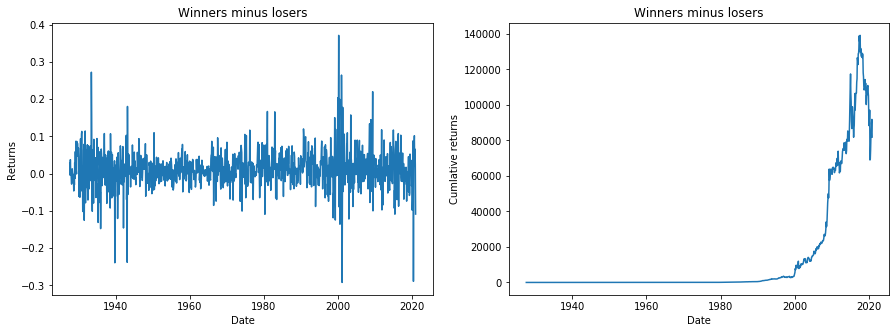

In [254]:
# Plot returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(result['Date'], result['WML'])
ax1.set_xlabel('Date') 
ax1.set_ylabel('Returns') 
ax1.set_title('Winners minus losers') 

ax2.plot(result['Date'], (1 + result['WML']).cumprod() - 1) 
ax2.set_xlabel('Date') 
ax2.set_ylabel('Cumlative returns') 
ax2.set_title('Winners minus losers') 

plt.show()